In [21]:
import statsmodels.formula.api as smf
import statsmodels as sm
import numpy as np
import cPickle
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('/Users/zbutler/research/fire_prediction')
import prediction.poisson_regression as pr
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from IPython import display
from time import sleep
from scipy.stats import pearsonr
from util.daymonth import increment_day, day2monthday, monthday2day
from geometry.grid_conversion import ak_bb
from geometry.grid_conversion import ak_bb
import geopandas as gpd

# Rain data

In [3]:
with open("data/precipitation/tp_ak.pkl") as fpkl:
    tp_ak = cPickle.load(fpkl)
print "Loaded %d length dict" % len(tp_ak)

Loaded 5738 length dict


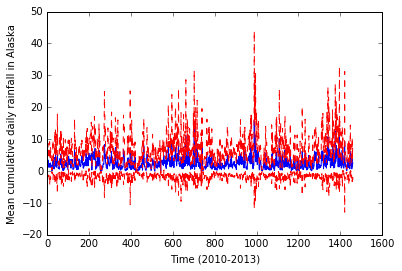

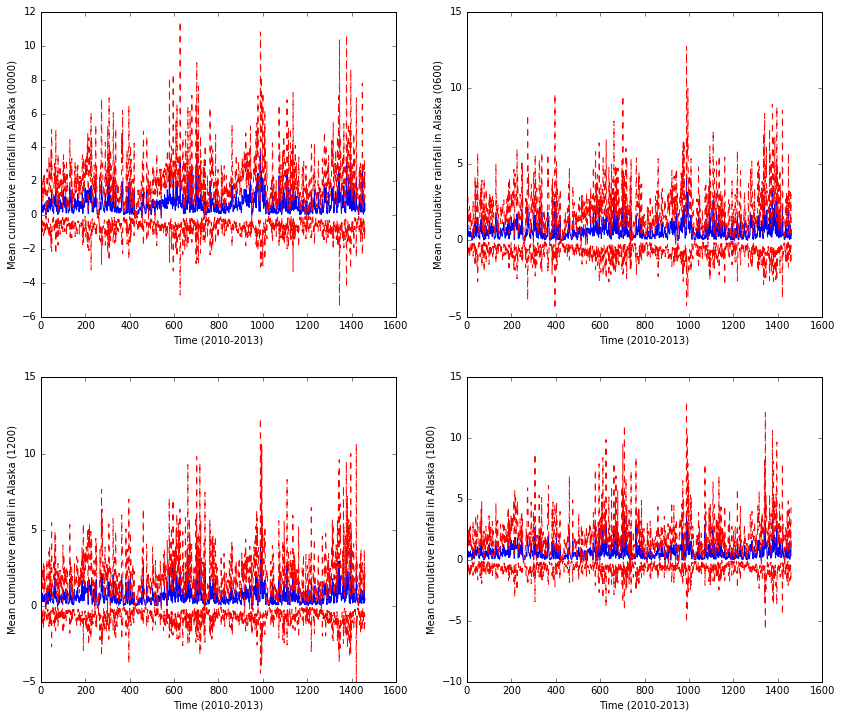

In [5]:
ex = tp_ak[(2010, 12, 1, '0600')]
hours = ['0000', '0600', '1200', '1800']
day = 1
month = 1
year = 2010
overall_mean_arr = []
overall_std_arr = []
hours_mean_arr = dict()
hours_std_arr = dict()
for hour in hours:
    hours_mean_arr[hour] = []
    hours_std_arr[hour] = []
tp_min = np.inf
tp_max = -np.inf
    
while year < 2014:
    overall_mat = np.zeros(ex.shape)
    for hour in hours:
        time_key = (year, month, day, hour)
        if time_key not in tp_ak:
            hours_mean_arr[hour].append(0)
            hours_std_arr[hour].append(0)
        else:
            mat = tp_ak[time_key]
            hours_mean_arr[hour].append(np.mean(mat))
            hours_std_arr[hour].append(np.std(mat))
            overall_mat += mat
            mn = np.min(mat)
            mx = np.max(mat)
            if mn < tp_min:
                tp_min = mn
            if mx > tp_max:
                tp_max = mx
    overall_mean_arr.append(np.mean(overall_mat))
    overall_std_arr.append(np.std(overall_mat))
    year, month, day = increment_day(year, month, day)
    
overall_mean_arr = np.array(overall_mean_arr)
overall_std_arr = np.array(overall_std_arr)
for hour in hours:
    hours_mean_arr[hour] = np.array(hours_mean_arr[hour])
    hours_std_arr[hour] = np.array(hours_std_arr[hour])    
    
plt.plot(overall_mean_arr, 'b-')
plt.plot(overall_mean_arr + overall_std_arr, 'r--')
plt.plot(overall_mean_arr - overall_std_arr, 'r--')
plt.ylabel('Mean cumulative daily rainfall in Alaska')
plt.xlabel('Time (2010-2013)')
plt.show()

fig,axarrs = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axarr = [None, None, None, None]
axarr[0] = axarrs[0][0]
axarr[1] = axarrs[0][1]
axarr[2] = axarrs[1][0]
axarr[3] = axarrs[1][1]
for i,hour in enumerate(hours):
    axarr[i].plot(hours_mean_arr[hour], 'b-')
    axarr[i].plot(hours_mean_arr[hour] + hours_std_arr[hour], 'r--')
    axarr[i].plot(hours_mean_arr[hour] - hours_std_arr[hour], 'r--')
    axarr[i].set_ylabel('Mean cumulative rainfall in Alaska (%s)' % hour)
    axarr[i].set_xlabel('Time (2010-2013)')
plt.show()

In [7]:
def aggregate_rainfall(tp_dict, min_year, max_year, shape):
    hours = ['0000','0600','1200','1800']
    ret_dict = dict()
    year = min_year
    month = 1
    day = 1
    min_val = np.inf
    max_val = -np.inf
    while year <= max_year:
        n_valid = 0
        mat = np.zeros(shape)
        for hour in hours:
            key = (year, month, day, hour)
            if key in tp_dict:
                n_valid += 1
                mat += tp_dict[key]
        if n_valid:
            agg_key = (year, month, day)
            ret_dict[agg_key] = (len(hours) / float(n_valid)) * mat
            mn = np.min(ret_dict[agg_key])
            mx = np.max(ret_dict[agg_key])
            if mn < min_val:
                min_val = mn
            if mx > max_val:
                max_val = mx
        year, month, day = increment_day(year,month,day)
    ret_dict['min'] = min_val
    ret_dict['max'] = max_val
    return ret_dict

tp_agg_dict = aggregate_rainfall(tp_ak, 2010, 2013, ex.shape)
print "Created aggregate dict of shape " + str(len(tp_agg_dict))

Created aggregate dict of shape 1453


In [8]:
# Now, bring it all together with fires
with open("data/ak_fires.pkl") as fpkl:
    ak_fires = cPickle.load(fpkl)
print "loaded %d fires" % len(ak_fires)

loaded 60544 fires


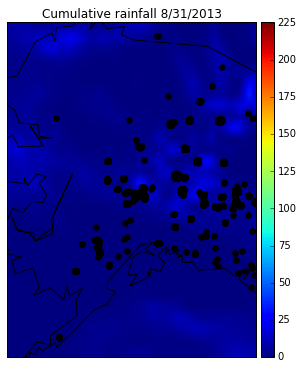

In [34]:
bb = ak_bb
day = 1
month = 7
year = 2013
ex = tp_agg_dict[(2010, 1, 1)]
shape = ex.shape

prev_lats = []
prev_longs = []
while month < 9:
    todays_fires = ak_fires[(ak_fires.year == year) & (ak_fires.month == month) &
                            (ak_fires.day == day)]
    display.clear_output(wait=True)
    plt.figure(figsize=(6,6))
    mp = Basemap(projection="merc",
                 lat_0=bb[0], lon_0=bb[2],
                 llcrnrlat=bb[0],
                 llcrnrlon=bb[2],
                 urcrnrlat=bb[1],
                 urcrnrlon=bb[3])
    mp.drawcoastlines()
    if (year,month,day) in tp_agg_dict:
        mp.imshow(tp_agg_dict[(year,month,day)], vmin=tp_agg_dict['min'], vmax=tp_agg_dict['max'])
    else:
        mp.imshow(np.zeros(shape), vmin=tp_agg_dict['min'], vmax=tp_agg_dict['max'])
    mp.colorbar()
    plt.title("Cumulative rainfall %d/%d/%d" % (month, day, year))
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'ro')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.show()
    sleep(.4)
    year, month, day = increment_day(year, month, day)

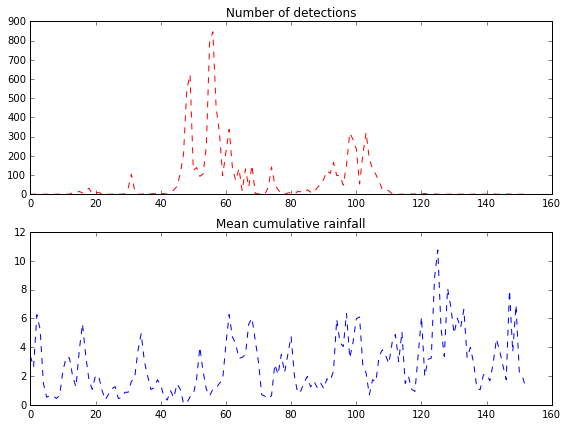

correlation in year 2010: (-0.20575051884172404, 0.010726595341937423)
correlation in year 2011: (-0.22939762931731869, 0.0043395772690601664)
correlation in year 2012: (-0.089948417029164049, 0.26884804961301356)
correlation in year 2013: (-0.13272148296099084, 0.10195381575524537)


In [36]:
# Huh that seemed weird. Let's look at a time series of average precipitation vs temperature
fires = []
rain = []

month = 5
day = 1
year = 2013
while month < 10:
    fires.append(len(ak_fires[(ak_fires.year == year) & (ak_fires.month == month) &
                            (ak_fires.day == day)]))
    if (year, month, day) in tp_agg_dict:
        rain.append(np.mean(tp_agg_dict[(year,month,day)]))
    else:
        rain.append(0)
    year,month,day = increment_day(year,month,day)
        
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6))
ax1 = plt.subplot(211)
plt.plot(fires, 'r--')
plt.title('Number of detections')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(rain, 'b--')
plt.title('Mean cumulative rainfall')
fig.tight_layout()
plt.show()

# correlations
for year in xrange(2010, 2014):
    fires = []
    rain = []

    month = 5
    day = 1
    while month < 10:
        fires.append(len(ak_fires[(ak_fires.year == year) & (ak_fires.month == month) &
                                (ak_fires.day == day)]))
        if (year, month, day) in tp_agg_dict:
            rain.append(np.mean(tp_agg_dict[(year,month,day)]))
        else:
            rain.append(0)
        year,month,day = increment_day(year,month,day)
        
    print "correlation in year %d: %s" % (year, str(pearsonr(fires, rain)))

# Lightning

In [12]:
# Throw in lightning! Only for the three years we have it though
with open("data/lightning/ground_lightning.pkl") as fpkl:
    ground_l = cPickle.load(fpkl)
print "Loaded %d ground lightning strikes" % len(ground_l)
ground_l.iloc[0:10]

Loaded 386144 ground lightning strikes


,amplitude,day,lat,lon,millisec,month,stroketype,year
0,-900.0,6,59.734187,-159.665223,965,3,GROUND_STROKE,2012
1,-800.0,7,57.151463,-160.337396,213,3,GROUND_STROKE,2012
2,-1000.0,8,56.797220,-164.046543,735,3,GROUND_STROKE,2012
3,-5100.0,8,60.136043,-155.737774,635,3,GROUND_STROKE,2012
4,-400.0,8,62.559145,-148.119411,818,3,GROUND_STROKE,2012
5,-4700.0,10,55.303014,-153.730459,46,3,GROUND_STROKE,2012
6,-900.0,10,60.749635,-164.928437,762,3,GROUND_STROKE,2012
7,-1200.0,11,55.822369,-162.586637,458,3,GROUND_STROKE,2012
8,-1500.0,11,56.415247,-162.217703,203,3,GROUND_STROKE,2012
9,-2500.0,12,55.291613,-161.638156,469,3,GROUND_STROKE,2012


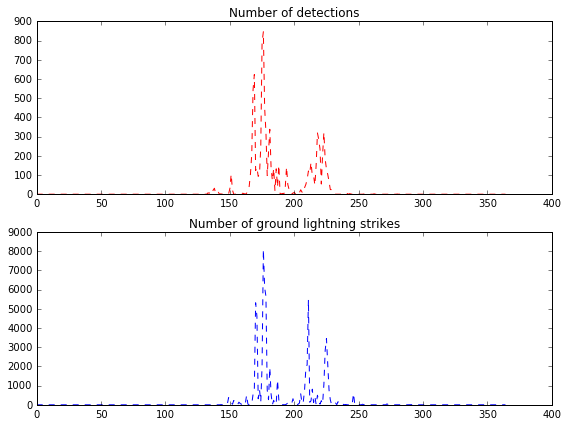

In [42]:
day = 1
month = 1
year = 2013
init_year = year

light = []
fire = []
while year == init_year:
    light.append(len(ground_l[(ground_l.day==day) & (ground_l.month==month) & (ground_l.year==year)]))
    fire.append(len(ak_fires[(ak_fires.day==day) & (ak_fires.month==month) & (ak_fires.year==year)]))
    year, month, day = increment_day(year, month, day)
    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6))
ax1 = plt.subplot(211)
plt.plot(fire, 'r--')
plt.title('Number of detections')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(light, 'b--')
plt.title('Number of ground lightning strikes')
fig.tight_layout()
plt.show()

# Prediction

In [22]:
with open('data/global_df.pkl') as fpkl:
    global_df = cPickle.load(fpkl)
summer_df = global_df[(global_df.dayofyear >= 134) & (global_df.dayofyear <= 242)]
X, y, y_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd', 'humidity', 'dayofyear', 'year'], normalize=[1,1,1,0,0], log_counts=True, autocorr_windows=[1])
X_1215 = X[(X.year < 2016) & (X.year > 2011)]
X_1215['lightning'] = pd.Series(np.zeros(len(X_1215)), index=X_1215.index)
day = 1
month = 1
year = 2012
strikes_per_day = []
while year < 2016:
    n_strikes = len(ground_l[(ground_l.day == day) & (ground_l.month == month) & (ground_l.year == year)])
    dayofyear = monthday2day(month, day, leapyear=(year % 4))
    if len(X_1215[(X_1215.dayofyear == dayofyear) & (X_1215.year == year)]):
        X_1215.lightning[(X_1215.dayofyear == dayofyear) & (X_1215.year == year)] = n_strikes
    year, month, day = increment_day(year, month, day)
X_1215['loglightning'] = np.log(X_1215.lightning + 1)
print X_1215.iloc[0:10]
testyear = 2013
X_train = X_1215[X_1215.year != testyear]
y_train = X_1215[X_1215.year != testyear].y
X_test = X_1215[X_1215.year == testyear]
y_test = X_1215[X_1215.year == testyear].y

Old df had 762 rows, new one without nans has 739


/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zbutler/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/zbutler/anaconda2/lib/

      n_det_1  normtemp   normvpd  normhumidity  dayofyear    year  y  \
213  1.098612 -2.455218 -1.453108      1.529439      135.0  2012.0  0   
214  0.000000 -2.290611 -1.358951      1.218755      136.0  2012.0  0   
215  0.000000 -1.731593 -1.015417      1.009771      137.0  2012.0  1   
216  0.693147 -1.421059 -0.626292      0.482165      138.0  2012.0  0   
217  0.000000 -1.332906 -0.498101      0.269378      139.0  2012.0  0   
218  0.000000 -1.329321 -0.487213      0.271555      140.0  2012.0  0   
219  0.000000 -1.122728 -0.440636      0.446839      141.0  2012.0  0   
220  0.000000 -1.098323 -0.616832      0.718869      142.0  2012.0  1   
221  0.693147 -1.054639 -0.726892      0.978389      143.0  2012.0  0   
222  0.000000 -0.982966 -0.835165      1.333669      144.0  2012.0  0   

     lightning  loglightning  
213        0.0       0.00000  
214        0.0       0.00000  
215        0.0       0.00000  
216        0.0       0.00000  
217        0.0       0.00000  
218       

/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
testyear = 2015
X_train = X_1215[X_1215.year != testyear]
y_train = X_1215[X_1215.year != testyear].y
X_test = X_1215[X_1215.year == testyear]
y_test = X_1215[X_1215.year == testyear].y

In [46]:
res0 = smf.glm('y ~ n_det_1', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res1 = smf.glm('y ~ n_det_1 + normhumidity', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res2 = smf.glm('y ~ n_det_1 + normhumidity + lightning', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res3 = smf.glm('y ~ n_det_1 + normhumidity + loglightning', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
y_hat0 = res0.predict(X_test)
y_hat1 = res1.predict(X_test)
y_hat2 = res2.predict(X_test)
y_hat3 = res3.predict(X_test)

eval_metrics = ['MSE', 'MedianSE', 'MeanAbsErr', 'RobustMSE']
print "Method\tTrain LL\tMSE\tMedianSE\tMeanAbsErr\tRobustMSE"
print "no covars\t%.2f\t" % (res0.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat0, metric=met),
print ""
print "no lightning\t%.2f\t" % (res1.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat1, metric=met),
print ""
print "lightning\t%.2f\t" % (res2.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat2, metric=met),
print ""
print "log lightning\t%.2f\t" % (res3.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat3, metric=met),
print ""

Method	Train LL	MSE	MedianSE	MeanAbsErr	RobustMSE
no covars	-4971.06	360099.40	447.91	235.26	25806.44	
no lightning	-4492.97	335575.81	702.23	226.87	21225.78	
lightning	-4339.83	444336.37	563.36	253.87	26068.29	
log lightning	-4352.53	366537.88	495.18	236.76	23698.89	


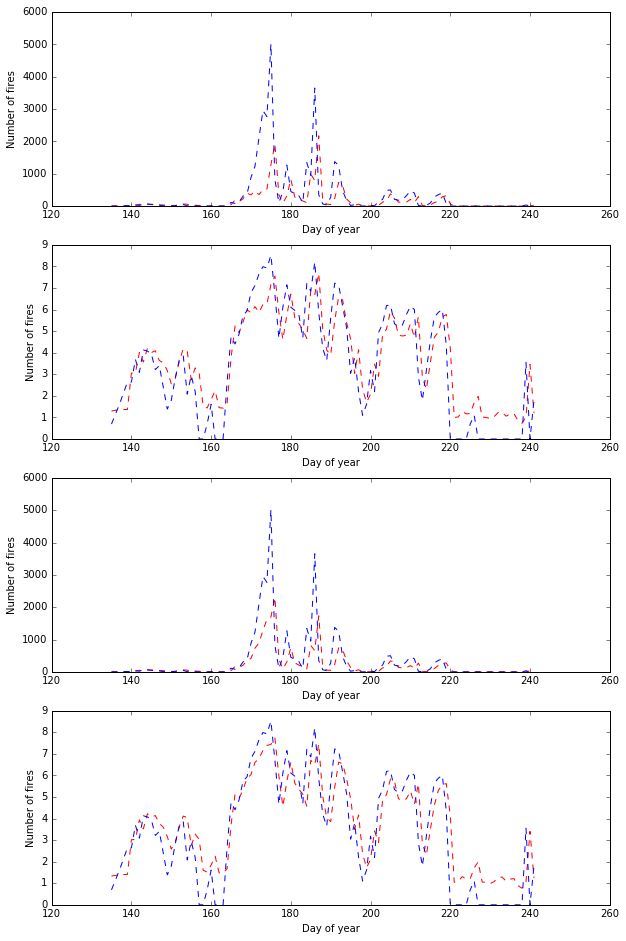

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,16))
ax1 = plt.subplot(411)
plt.plot(X_test.dayofyear, y_hat2, 'r--')
plt.plot(X_test.dayofyear, y_test, 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax2 = plt.subplot(412, sharex=ax1)
plt.plot(X_test.dayofyear, np.log(y_hat2+1), 'r--')
plt.plot(X_test.dayofyear, np.log(y_test+1), 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(X_test.dayofyear, y_hat1, 'r--')
plt.plot(X_test.dayofyear, y_test, 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(X_test.dayofyear, np.log(y_hat1+1), 'r--')
plt.plot(X_test.dayofyear, np.log(y_test+1), 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
plt.show()

In [39]:
tp_ak[(2013,7,13,'0000')]

array([], shape=(0, 52), dtype=float64)

# Rainfall 2: electric boogaloo

In [52]:
with open("data/gfs/temp_dict.pkl") as fpkl:
    temp_dict = cPickle.load(fpkl)
print temp_dict['lats']
print temp_dict['lons']

[[ 90.   90.   90.  ...,  90.   90.   90. ]
 [ 89.5  89.5  89.5 ...,  89.5  89.5  89.5]
 [ 89.   89.   89.  ...,  89.   89.   89. ]
 ..., 
 [-89.  -89.  -89.  ..., -89.  -89.  -89. ]
 [-89.5 -89.5 -89.5 ..., -89.5 -89.5 -89.5]
 [-90.  -90.  -90.  ..., -90.  -90.  -90. ]]
[[   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 ..., 
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]]


In [67]:
lats = temp_dict['lats']
lons = temp_dict['lons']
gfs_bb_0 = np.where(lats[:,0] < ak_bb[1])[0][0]
gfs_bb_1 = np.where(lats[:,0] > ak_bb[0])[0][-1]   # Since lats start at the top and go down, have to reverse these
gfs_bb_2 = np.where(lons[0,:] > (ak_bb[2] % 360))[0][0]
gfs_bb_3 = np.where(lons[0,:] < (ak_bb[3] % 360))[0][-1]
fairbanks_row = np.where(lats[:,0] < 65)[0][0]
fairbanks_col = np.where(lons[0,:] > (-148 % 360))[0][0]
fairbanks_row_ind = fairbanks_row - gfs_bb_0
fairbanks_col_ind = fairbanks_col - gfs_bb_2
print fairbanks_row_ind
print fairbanks_col_ind

12
34


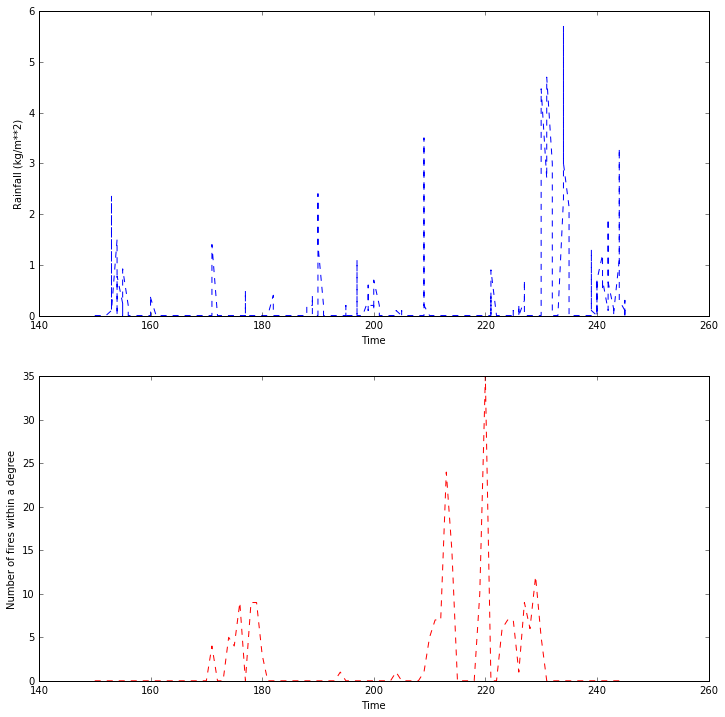

In [69]:
rain_arr = []
time_arr = []
fire_arr = []
hours = ['0000', '0600', '1200', '1800']
month, day = day2monthday(150)
year = 2013
while year < 2014:
    leapyear = year%4 == 0
    for hour in hours:
        tup = (year, month, day, hour)
        if tup not in tp_ak:
            continue
        pos_in_day = int(hour) / (24. * 100.)

        dayofyear = monthday2day(month, day, leapyear=leapyear)
        if dayofyear > 245:
            break
        pos_in_year = (dayofyear + pos_in_day) / (365. + leapyear)
        time_arr.append(dayofyear)#year + pos_in_year)
        rain_arr.append(tp_ak[tup][fairbanks_row_ind, fairbanks_col_ind])
        fire_arr.append(len(ak_fires[(ak_fires.year==year) & (ak_fires.day==day) & (ak_fires.month==month) & 
                                     (ak_fires.lat > 64) & (ak_fires.lat < 66) & (ak_fires.long >-151) & 
                                     (ak_fires.long < -149)]))
    year, month, day = increment_day(year, month, day)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
ax1 = plt.subplot(211)
plt.plot(time_arr, rain_arr, 'b--')
plt.xlabel('Time')
plt.ylabel('Rainfall (kg/m**2)')
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(time_arr, fire_arr, 'r--')
plt.xlabel('Time')
plt.ylabel('Number of fires within a degree')
plt.savefig('pics/rainfall_fire_fairbanks.png')
plt.show()